<a href="https://colab.research.google.com/github/ankitdv98/Multiclass-classification-on-stackoverflow-data/blob/main/multiclass_classification_on_Stack_Overflow_questions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content/drive/MyDrive/Kaggle/Stackoverflow classification
!ls

/content/drive/MyDrive/Kaggle/Stackoverflow classification
stack_overflow_16k.tar.gz


In [2]:
!tar -xf stack_overflow_16k.tar.gz

In [3]:
import matplotlib.pyplot as plt
import re
import string
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


In [36]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)


Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [ ]:
for text_batch, label_batch in raw_train_ds.take(2):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])


In [38]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 0 corresponds to", raw_train_ds.class_names[2])
print("Label 1 corresponds to", raw_train_ds.class_names[3])



Label 0 corresponds to csharp
Label 1 corresponds to java
Label 0 corresponds to javascript
Label 1 corresponds to python


In [39]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)


Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [40]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'test', 
    batch_size=batch_size)


Found 8000 files belonging to 4 classes.


# Data Preparation

In [104]:
max_features = 10000
embedding_dim = 128
sequence_length = 250

vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [105]:
# Make a text-only dataset bringing text and label in lambda and keeping text only
text_ds = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

#Vectorizing the data

In [106]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [113]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[4], label_batch[4]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))


Review tf.Tensor(b'"simple class in blank from math import pi..class sphere(object):..    def __init__(self,radius):.        self.radius = radius..    def get_radius(self):.        return radius..    def surfacearea(self):.        return 4*pi*radius**2..    def volume(self):.        return (4//3)*pi*radius**3..radius = input(""please enter your radius:"")..print sphere.get_radius().print sphere.surfacearea().print sphere.volume()...i need to write the program that prompts the user for a radius then uses your sphere class to output the surface area and volume of a sphere. and i get a type error unbound method get_radius() must be called with sphere instance as first argument(got nothing instead). any way to solve this problemo?"\n', shape=(), dtype=string)
Label python
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[ 241,   29,    7,   16,   31, 1107,  141,    1,    1,  163,    1,
           1, 1061,  163,    1,   27, 1061,  163,    1,   27,    1,  163,
      

In [114]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))


1287 --->  scissors
 313 --->  source
Vocabulary size: 10000


In [115]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


# Building Model

In [116]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 128)         1280128   
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
global_average_pooling1d_4 ( (None, 128)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 516       
Total params: 1,280,644
Trainable params: 1,280,644
Non-trainable params: 0
_________________________________________________________________


In [117]:
model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer='adam', 
    metrics=['accuracy'])

#Model training

In [118]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs= 10)

Epoch 1/10
200/200 [==============================] - 11s 51ms/step - loss: 1.3737 - accuracy: 0.3223 - val_loss: 1.3138 - val_accuracy: 0.5706
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 1.2754 - accuracy: 0.5662 - val_loss: 1.1418 - val_accuracy: 0.6712
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 1.0911 - accuracy: 0.6656 - val_loss: 0.9635 - val_accuracy: 0.7269
Epoch 4/10
200/200 [==============================] - 3s 15ms/step - loss: 0.9161 - accuracy: 0.7357 - val_loss: 0.8331 - val_accuracy: 0.7550
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 0.7833 - accuracy: 0.7725 - val_loss: 0.7422 - val_accuracy: 0.7775
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 0.6866 - accuracy: 0.8044 - val_loss: 0.6779 - val_accuracy: 0.7869
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 0.6121 - accuracy: 0.8248 - val_loss: 0.6307 - val_accuracy: 0.800

#Model evaluation

In [119]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 8s 31ms/step - loss: 0.5919 - accuracy: 0.7889
Loss:  0.5918772220611572
Accuracy:  0.7888749837875366


In [120]:
history_dict = history.history
history_dict.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

#Model Visualize

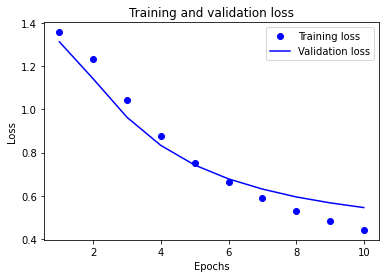

In [121]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


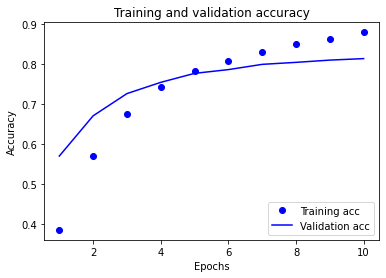

In [122]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()


# Exporting the model

In [123]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('softmax')
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)


250/250 [==============================] - 9s 34ms/step - loss: 0.5881 - accuracy: 0.7884
0.7888749837875366


In [131]:
import numpy as np
examples = [
  "i am having trouble with the datetime object in python can somebody tell how to retrieve the date from the date column?",
  "package org.apache.commons.lang3 does not exist in jetbrains i was making a client (mod) for a game called Minecraft but when i tried doing this it just popped up and it didn't work please if ...",
  "I can't understand why the file is not loaded with the right encoding My python script: from tensorflow.keras.models import load_model model = load_model('example_model.h5') This is my console output:... ",
  """Adding pandas dataframe to the initial db.sqlite database in django + no duplicates
How can i convert and assign the fetched information (that is modified with pandas) to a predefined model + not include duplicate rows? As i understood, pandas.DataFrame.to_sql should be used, but i'm ... """,
"I'm trying to make an accordion with HTML, CSS, and Javascript. I made it but it displays text from an array in only one accordion item, and not on the other accordion divs and other buttons, who are ... "

]

pred= export_model.predict(examples)
for x in pred:
  labl= np.argmax(x)
  print("Label corresponds to", raw_train_ds.class_names[labl])


Label corresponds to java
Label corresponds to python
Label corresponds to python
Label corresponds to python
Label corresponds to javascript
